# Prediction

Both classification and regression models implement tools for prediction. Classifiers provide `predict_proba` (probabilities) and `predict` (labels), while regressors provide `predict` (continuous values) as any scikit-learn estimator would. However, they are retrieved differently.

The prediction can be either done using a single nearest local model or using the ensemble of local models available within the bandwidth. At the same time, the prediction from local model(s) can be fused with the global model to combine the best from both worlds, following Georganos et al (2021).

## Classification prediction

See that in action with a classifier:

In [1]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics
from sklearn.model_selection import train_test_split

from gwlearn.ensemble import GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.south")).to_crs(5070)

gdf["point"] = gdf.representative_point()
gdf = gdf.set_geometry("point").set_index("FIPS")

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

Leave out some locations for prediction later.

In [3]:
X_train, X_test, y_train, y_test, geom_train, geom_test = train_test_split(
    X, y, gdf.geometry, test_size=0.1
)

Fit the model using the training subset. If you plan to do the prediction, you need to store the local models, which is False by default. When set to True, all the models are kept in memory, so be careful with large datasets. If given a path, all the models will be stored on disk instead, freeing the memory load.

In [5]:
gwrf = GWLogisticRegression(
    bandwidth=150,
    fixed=False,
    keep_models=True,
)
gwrf.fit(
    X_train,
    y_train,
    geometry=geom_train,
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,True
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None
,batch_size,None


### Using the nearest local model

Now, you can use the test subset to get the prediction. The default behaviour finds the nearest local model and uses it to get the prediction.

In [6]:
proba = gwrf.predict_proba(X_test, geometry=geom_test)
proba

,False,True
FIPS,,
37031,0.540415,0.459585
40113,0.927652,0.072348
24031,0.640991,0.359009
48357,NaN,NaN
21201,0.873015,0.126985
...,...,...
24001,0.863602,0.136398
48145,0.712549,0.287451
47105,0.807346,0.192654


You can then check the accuracy of this prediction. Note that similarly to fitting, there might be locations that return NA, if the local model was not fitted due to invariance.

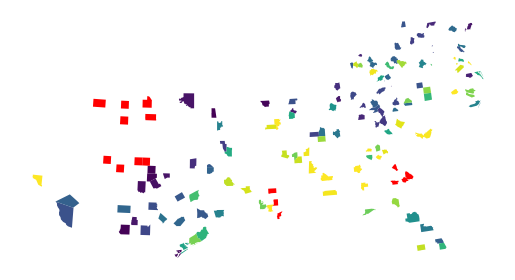

In [8]:
gpd.GeoDataFrame(proba, geometry=gdf['geometry']).plot(
    True, missing_kwds=dict(color="red")
).set_axis_off()

The missing values have been linked to models that were not fitted. You can check all of those visually by plotting the focal prediction.

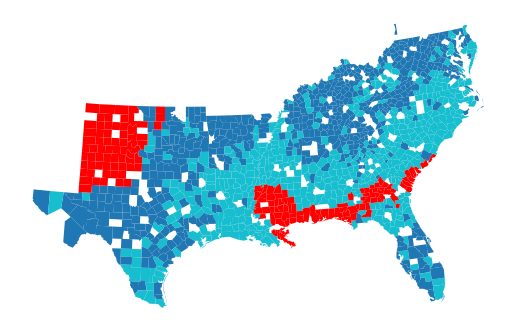

In [11]:
gpd.GeoDataFrame({"pred": gwrf.pred_}, geometry=gdf['geometry']).plot("pred", missing_kwds=dict(color="red")).set_axis_off()

Filter it out and measure the performance on the left-out sample.

In [12]:
na_mask = proba.isna().any(axis=1)

pred = proba[~na_mask].idxmax(axis=1).astype(bool)

metrics.accuracy_score(y_test[~na_mask], pred)

0.7857142857142857

### Using the ensemble of local models

In case of the ensemble-based prediction, the process works as follows:

1. For a new location on which you want a prediction, identify local models within the set bandwidth. If `bandwidth=None`, uses the bandwidth set at the fit time.
2. Apply the kernel function used to train the model to derive weights of each of the local models.
3. Make prediction using each of the local models in the bandwidth.
4. Make weighted average of predictions based on the kernel weights.
5. For classifiers, normalize the result to ensure sum of probabilities is 1.

Note that given the prediction is pulled from an ensemble of local models, it is not particularly performant. However, it shall be spatially robust.

In [13]:
proba_ensemble = gwrf.predict_proba(X_test, geometry=geom_test, bandwidth=100)
proba_ensemble

,False,True
FIPS,,
37031,0.621297,0.378703
40113,0.924314,0.075686
24031,0.635348,0.364652
48357,0.920977,0.079023
21201,0.844610,0.155390
...,...,...
24001,0.860320,0.139680
48145,0.674498,0.325502
47105,0.838859,0.161141


Given it relies on an ensemble, not a single nearest model, it returns NaN only when all the local models within the bandwidth were not fitted.

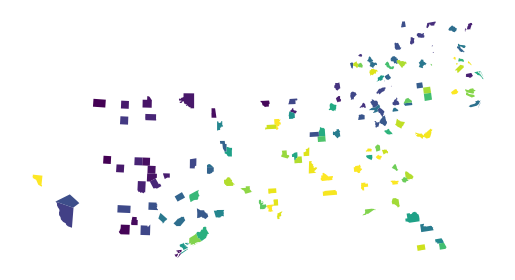

In [15]:
gpd.GeoDataFrame(proba_ensemble, geometry=gdf['geometry']).plot(
    True, missing_kwds=dict(color="red")
).set_axis_off()

This is one of the benefits of the ensemble prediction. Another is theoretical spatial robustness. Nevertheless, the actual metrics are typically very similar between the models.

In [16]:
na_mask = proba_ensemble.isna().any(axis=1)
pred = proba_ensemble[~na_mask].idxmax(axis=1).astype(bool)

metrics.accuracy_score(y_test[~na_mask], pred)

0.7887323943661971

### Fusing with the global model

Predictions from local models can be fused with the predictions from the global model as a weighted average, by assigning non-zero weight to global model.

In [17]:
proba_fused = gwrf.predict_proba(X_test, geometry=geom_test, global_model_weight=0.25)
proba_fused

,False,True
FIPS,,
37031,0.560711,0.439289
40113,0.884301,0.115699
24031,0.641662,0.358338
48357,0.756186,0.243814
21201,0.878726,0.121274
...,...,...
24001,0.867646,0.132354
48145,0.683489,0.316511
47105,0.786916,0.213084


When prediction from local models yields NaN, it is ignored and the global prediction is used instead.

In [18]:
pred_fused = gwrf.predict(X_test, geometry=geom_test, global_model_weight=0.25)

metrics.accuracy_score(y_test, pred_fused)

0.795774647887324

You can see that the accuracy is slightly better but keep in mind that this is only a toy example and specific strategy for fusing local and global predictions needs to be tested on your use case.

## Prediction with regressors

Regression models also implement `predict` method following the same logic as classifiers. Let's see that in action with a `GWLinearRegression`.

In [19]:
from gwlearn.linear_model import GWLinearRegression

Prepare the data with a continuous target variable.

In [20]:
y_reg = gdf["FH90"]  # Use the continuous variable directly

X_train_reg, X_test_reg, y_train_reg, y_test_reg, geom_train_reg, geom_test_reg = (
    train_test_split(X, y_reg, gdf.geometry, test_size=0.1, random_state=42)
)

Fit the regression model with `keep_models=True` to enable prediction.

In [21]:
gwrf_reg = GWLinearRegression(
    bandwidth=150,
    fixed=False,
    keep_models=True,
)
gwrf_reg.fit(
    X_train_reg,
    y_train_reg,
    geometry=geom_train_reg,
)

,bandwidth,150
,fixed,False
,kernel,'bisquare'
,include_focal,True
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,True
,temp_folder,None
,batch_size,None


Make predictions on the test set using the `predict` method.

In [22]:
pred_reg = gwrf_reg.predict(X_test_reg, geometry=geom_test_reg)
pred_reg

FIPS
05019    11.305102
28019    15.452676
40103    10.472469
21183    11.599020
21233    11.808220
           ...    
40151     7.958798
01125    19.985145
37181    21.442915
01055    16.079282
51097    15.131518
Length: 142, dtype: float64

Visualize the predicted values spatially.

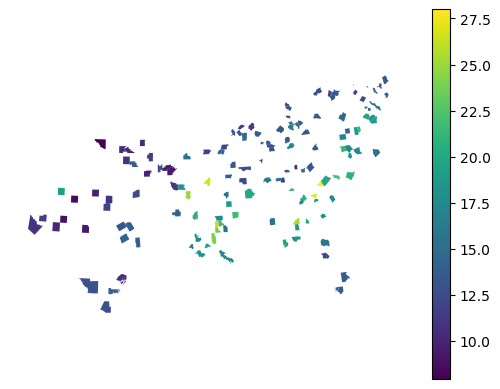

In [23]:
gpd.GeoDataFrame({"prediction": pred_reg}, geometry=gdf['geometry']).plot(
    "prediction", legend=True
).set_axis_off()

Evaluate the prediction performance using common regression metrics.

In [24]:
print(f"R2 score: {metrics.r2_score(y_test_reg, pred_reg):.3f}")
print(f"RMSE: {metrics.root_mean_squared_error(y_test_reg, pred_reg):.3f}")

R2 score: 0.515
RMSE: 3.219


The ensemble prediction is available analogously to classifiers.

In [25]:
pred_reg_ensemble = gwrf_reg.predict(X_test_reg, geometry=geom_test_reg, bandwidth=None)
pred_reg_ensemble

FIPS
05019    12.559598
28019    15.694336
40103    10.558348
21183    11.902395
21233    11.823882
           ...    
40151     8.418367
01125    18.759463
37181    20.651287
01055    16.448296
51097    15.117892
Length: 142, dtype: float64

In [26]:
print(f"R2 score: {metrics.r2_score(y_test_reg, pred_reg_ensemble):.3f}")
print(f"RMSE: {metrics.root_mean_squared_error(y_test_reg, pred_reg_ensemble):.3f}")

R2 score: 0.515
RMSE: 3.219


Similarly, you can fuse predictions from local and global models.

In [27]:
pred_reg_fused = gwrf_reg.predict(
    X_test_reg, geometry=geom_test_reg, global_model_weight=0.25
)
pred_reg_fused

FIPS
05019    11.775020
28019    15.095594
40103    10.843544
21183    11.523029
21233    11.747615
           ...    
40151     8.099005
01125    19.299812
37181    21.073540
01055    16.451967
51097    14.972267
Length: 142, dtype: float64

In [28]:
print(f"R2 score: {metrics.r2_score(y_test_reg, pred_reg_fused):.3f}")
print(f"RMSE: {metrics.root_mean_squared_error(y_test_reg, pred_reg_fused):.3f}")

R2 score: 0.520
RMSE: 3.203


As you can see, contrary to the classification task, the fusion of global prediction to the local one did not improve the model performance in this case. However, this is very much case dependent.